In [ ]:
# 1
import tensorflow.keras as keras
print(keras.__version__)


3.8.0


In [ ]:
# 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, send_file

# Load data
file_path = 'Data 27 hari.csv'
data = pd.read_csv(file_path, delimiter=';')

# Data preprocessing
data['Time'] = pd.to_datetime(data['Time'], format='%d/%m/%Y %H.%M')

# Replace non-numeric values with NaN in the relevant columns and convert to numeric
data['Temp Winding'] = pd.to_numeric(data['Temp Winding'].str.replace(',', '.'), errors='coerce')
data['MW'] = pd.to_numeric(data['MW'].str.replace(',', '.'), errors='coerce')
data['Mvar'] = pd.to_numeric(data['Mvar'].str.replace(',', '.'), errors='coerce')

# Drop rows with NaN values after the conversion
data.dropna(inplace=True)

# Initialize starttime variable with the time of the first data point
starttime = data['Time'].iloc[0]

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

# Apply the function to calculate Duration
data['Duration'] = data.apply(calculate_duration, axis=1)

# Save the cleaned and updated data
data.head()


,Time,Temp Winding,Mvar,MW,Duration
0,2024-12-24 12:21:00,75.115997,8.858432,0.155644,0.0
1,2024-12-24 12:22:00,73.420670,1.512335,0.155644,0.0
2,2024-12-24 12:23:00,71.759880,0.704978,0.155644,0.0
3,2024-12-24 12:24:00,70.147820,0.388237,0.155644,0.0
4,2024-12-24 12:25:00,68.571434,0.228889,0.153084,0.0


In [ ]:
# 3
data.sample(20)

,Time,Temp Winding,Mvar,MW,Duration
39981,2025-01-21 06:42:00,38.806271,-0.109867,0.146489,0.0
20867,2025-01-08 00:08:00,76.727715,20.783484,144.768402,194340.0
36894,2025-01-19 03:15:00,63.380527,-17.485668,105.038170,32820.0
22632,2025-01-09 05:33:00,56.800980,-0.106159,0.149018,0.0
17392,2025-01-05 14:13:00,37.948719,-0.109867,0.155644,0.0
4026,2024-12-27 07:27:00,50.891335,-0.109867,0.153078,0.0
5089,2024-12-28 01:10:00,52.907482,-0.109867,0.149053,0.0
16575,2025-01-05 00:36:00,39.462761,-0.113886,0.155644,0.0
1170,2024-12-25 07:51:00,51.121758,-0.109867,0.155644,0.0
31669,2025-01-15 12:10:00,67.426537,0.073244,0.155644,0.0


In [ ]:
from google.colab import files
# Simpan data ke file CSV
output_file = 'Data 1 bulan with duration.csv'
data.to_csv(output_file, index=False)

# Unduh file CSV
print(f"File '{output_file}' telah dibuat. Anda dapat mengunduhnya di bawah ini:")
files.download(output_file)

File 'Data 1 bulan with duration.csv' telah dibuat. Anda dapat mengunduhnya di bawah ini:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # 2.5
# # Drop baris dengan Duration = 0
# data = data[data['Duration'] > 0]
# data.head()

,Time,Temp Winding,Mvar,MW,Duration
1,2024-12-24 11:18:00,76.678879,5.501629,149.467255,60.0
2,2024-12-24 11:19:00,76.719971,3.995501,149.576401,120.0
3,2024-12-24 11:20:00,76.692734,5.293373,149.424744,180.0
4,2024-12-24 11:21:00,76.664818,2.908344,149.746079,240.0
5,2024-12-24 11:22:00,76.678879,3.265673,151.833191,300.0


In [ ]:
data.sample(20)

,Time,Temp Winding,Mvar,MW,Duration
33720,2025-01-16 21:17:00,73.854088,19.308924,136.662521,116280.0
35309,2025-01-17 23:46:00,66.164536,-5.412691,122.363380,39540.0
22822,2025-01-09 07:39:00,73.455437,12.106060,146.399094,7260.0
33917,2025-01-17 00:34:00,71.125191,-19.888432,130.665848,128100.0
24127,2025-01-10 05:24:00,69.059830,-1.568054,152.480621,1020.0
2791,2024-12-26 09:48:00,72.087914,18.043684,148.746948,3240.0
32568,2025-01-16 02:05:00,65.605774,-26.395514,105.139999,47160.0
34132,2025-01-17 04:09:00,68.557602,-28.346277,115.033546,141000.0
20600,2025-01-07 18:37:00,73.916756,20.455029,138.326004,174480.0
3513,2024-12-26 21:50:00,67.573746,1.504900,99.886971,46560.0


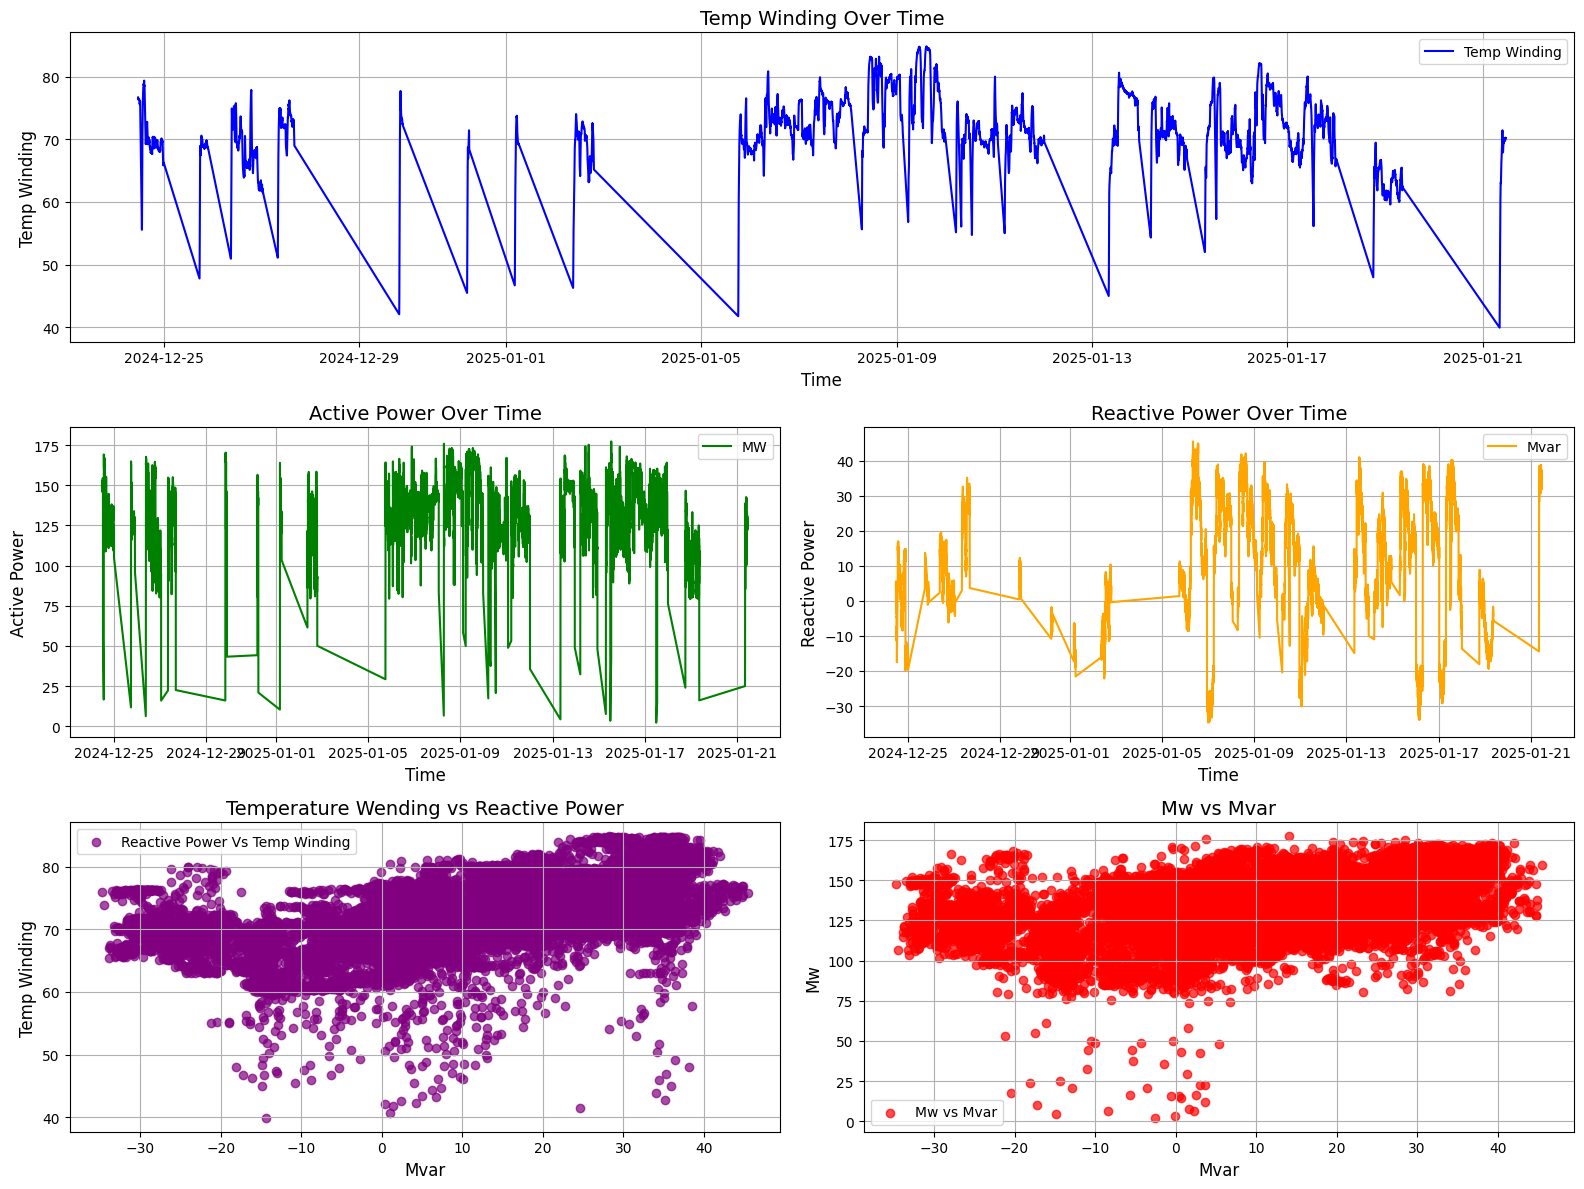

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Perbaikan dan visualisasi data
plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Plot Temperature Wending Over Time
ax1 = plt.subplot(gs[0, :])
ax1.plot(data['Time'], data['Temp Winding'], label='Temp Winding', color='blue')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Temp Winding', fontsize=12)
ax1.set_title('Temp Winding Over Time', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot Beban Unit 1 Over Time
ax2 = plt.subplot(gs[1, 0])
ax2.plot(data['Time'], data['MW'], label='MW', color='green')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Active Power', fontsize=12)
ax2.set_title('Active Power Over Time', fontsize=14)
ax2.legend()
ax2.grid(True)

# Plot Duration Over Time
ax3 = plt.subplot(gs[1, 1])
ax3.plot(data['Time'], data['Mvar'], label='Mvar', color='orange')
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Reactive Power', fontsize=12)
ax3.set_title('Reactive Power Over Time', fontsize=14)
ax3.legend()
ax3.grid(True)

# Scatter plot Duration vs Temperature Wending
ax4 = plt.subplot(gs[2, 0])
ax4.scatter(data['Mvar'], data['Temp Winding'], label='Reactive Power Vs Temp Winding', color='purple', alpha=0.7)
ax4.set_xlabel('Mvar', fontsize=12)
ax4.set_ylabel('Temp Winding', fontsize=12)
ax4.set_title('Temperature Wending vs Reactive Power', fontsize=14)
ax4.legend()
ax4.grid(True)

# Scatter plot Duration vs Beban Unit 1
ax5 = plt.subplot(gs[2, 1])
ax5.scatter(data['Mvar'], data['MW'], label='Mw vs Mvar', color='red', alpha=0.7)
ax5.set_xlabel('Mvar', fontsize=12)
ax5.set_ylabel('Mw', fontsize=12)
ax5.set_title('Mw vs Mvar', fontsize=14)
ax5.legend()
ax5.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


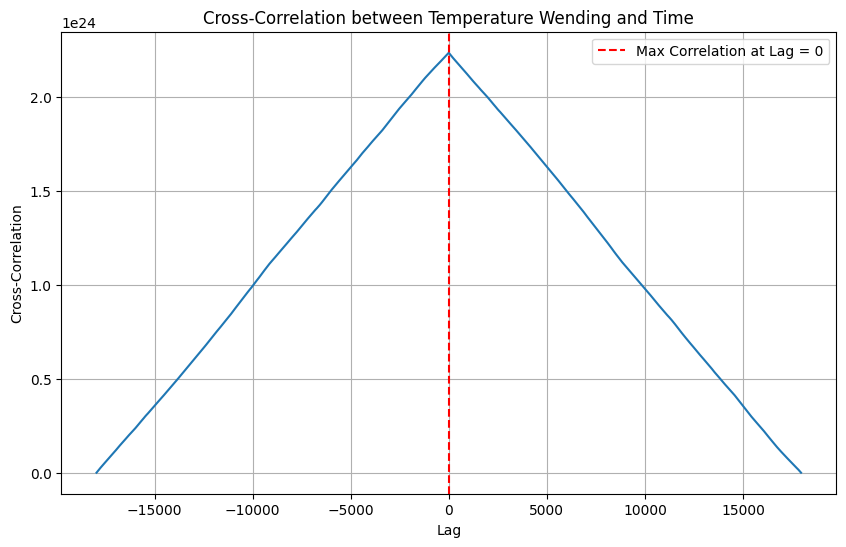

Maximum cross-correlation between 'Temperature Wending' and 'Time' occurs at lag 0


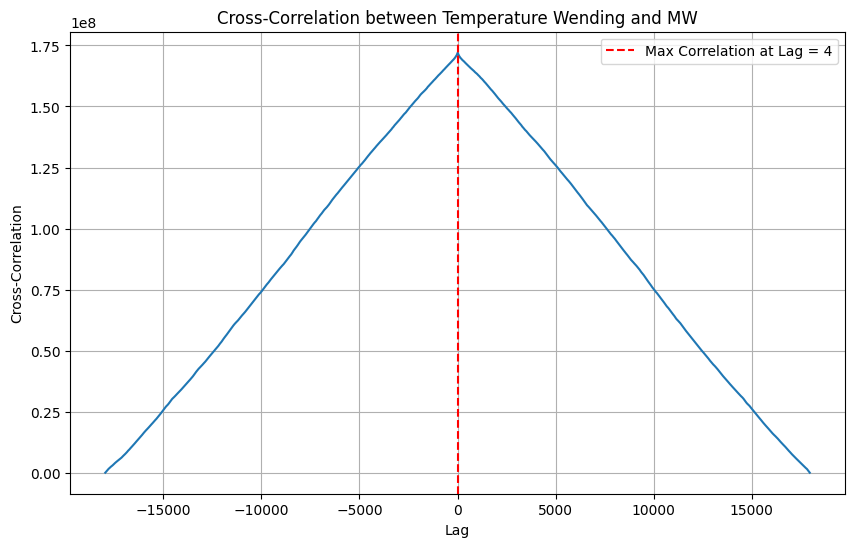

Maximum cross-correlation between 'Temperature Wending' and 'MW' occurs at lag 4


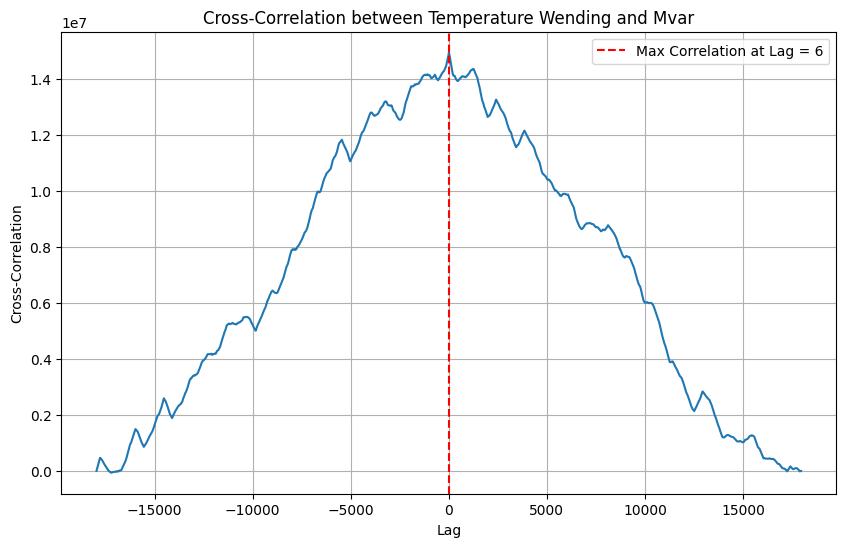

Maximum cross-correlation between 'Temperature Wending' and 'Mvar' occurs at lag 6


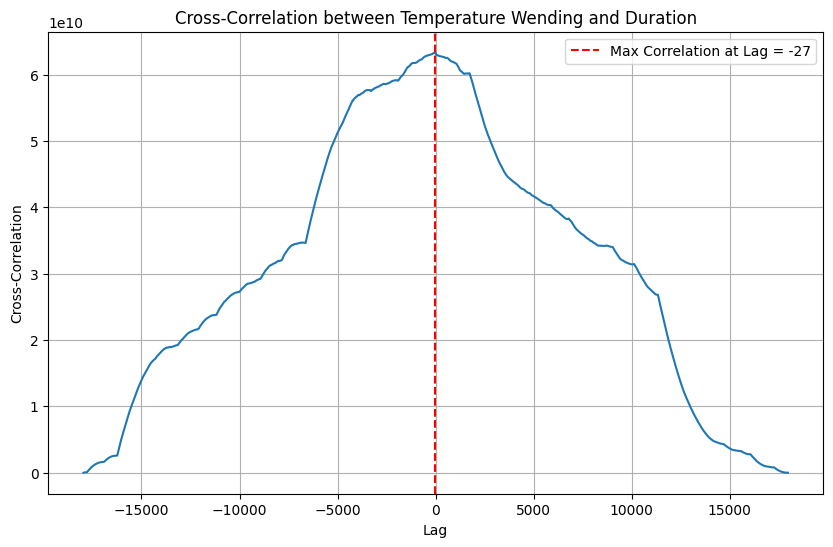

Maximum cross-correlation between 'Temperature Wending' and 'Duration' occurs at lag -27


In [ ]:
from scipy import signal

# Calculate cross-correlation for each feature with 'Temperature Wending'
features = ['Time','MW','Mvar','Duration']  # Add other features if needed

for feature in features:
    correlation = signal.correlate(data['Temp Winding'], data[feature], mode='full')
    lags = signal.correlation_lags(len(data['Temp Winding']), len(data[feature]), mode='full')

    # Find the lag with the maximum correlation
    max_correlation_index = np.argmax(correlation)
    max_lag = lags[max_correlation_index]

    plt.figure(figsize=(10, 6))
    plt.plot(lags, correlation)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(f'Cross-Correlation between Temperature Wending and {feature}')
    plt.axvline(x=max_lag, color='r', linestyle='--', label=f'Max Correlation at Lag = {max_lag}')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Maximum cross-correlation between 'Temperature Wending' and '{feature}' occurs at lag {max_lag}")

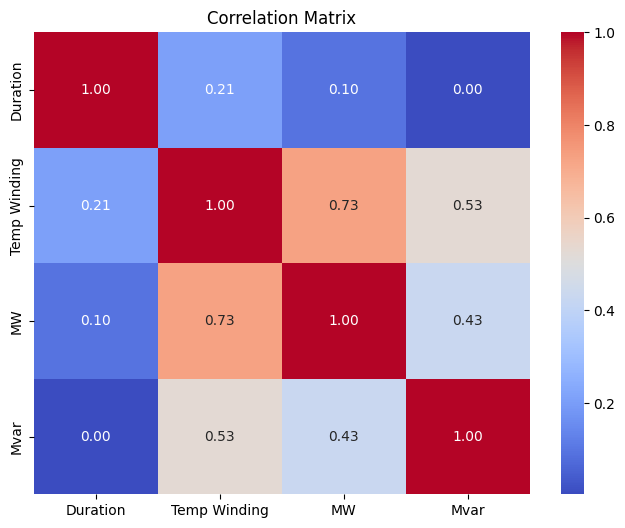

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation matrix
correlation_matrix = data[['Duration','Temp Winding', 'MW','Mvar']].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 4
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#New dataframe with only training data - 5 columns
df_for_training = data[['Temp Winding', 'Mvar', 'MW','Duration']].astype(float)

# df_for_plot=df_for_training.tail(500)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 20  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))



trainX shape == (40235, 20, 4).
trainY shape == (40235, 1).


In [ ]:
# 5
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
import tensorflow.keras.backend as K

# Define custom RMSE metric function
def rmse_metric(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Define custom R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Sum of squared residuals
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return (1 - ss_res / (ss_tot + K.epsilon()))  # Return R²

# define the model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

# Compile model with MSE, MAE, MAPE, RMSE, and R² metrics
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError(), rmse_metric, r2_metric])

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss',    # Monitor validation loss
                               patience=5,            # Number of epochs with no improvement before stopping
                               restore_best_weights=True,  # Restore the best model weights
                               verbose=1)

# Define ModelCheckpoint callback to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('LSTM_Best_Model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6
import joblib

# Train the model with callbacks
history = model.fit(
    trainX,trainY,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping,model_checkpoint, reduce_lr]  # Add callbacks here
)

# Save the final model and scaler for future predictions (even if it's not the best model)
model.save('lstm_model_insyaallah_final_final.keras')  # Save the final model
# Simpan scaler ke file
joblib.dump(scaler, 'LSTM_Scaler.pkl')


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00531, saving model to best_model_final_lstm_final.keras
2012/2012 - 58s - 29ms/step - loss: 0.0318 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 15.8549 - mean_squared_error: 0.0318 - r2_metric: 0.9659 - rmse_metric: 0.1644 - val_loss: 0.0053 - val_mean_absolute_error: 0.0570 - val_mean_absolute_percentage_error: 9.0669 - val_mean_squared_error: 0.0053 - val_r2_metric: -1.3797e+02 - val_rmse_metric: 0.0576 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 0.00531 to 0.00238, saving model to best_model_final_lstm_final.keras
2012/2012 - 66s - 33ms/step - loss: 0.0243 - mean_absolute_error: 0.1139 - mean_absolute_percentage_error: 14.1568 - mean_squared_error: 0.0243 - r2_metric: 0.9735 - rmse_metric: 0.1511 - val_loss: 0.0024 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 6.4622 - val_mean_squared_error: 0.0024 - val_r2_metric: -1.3544e+02 - val_rmse_metric: 0.0420 - learni

['scaler.pkl']

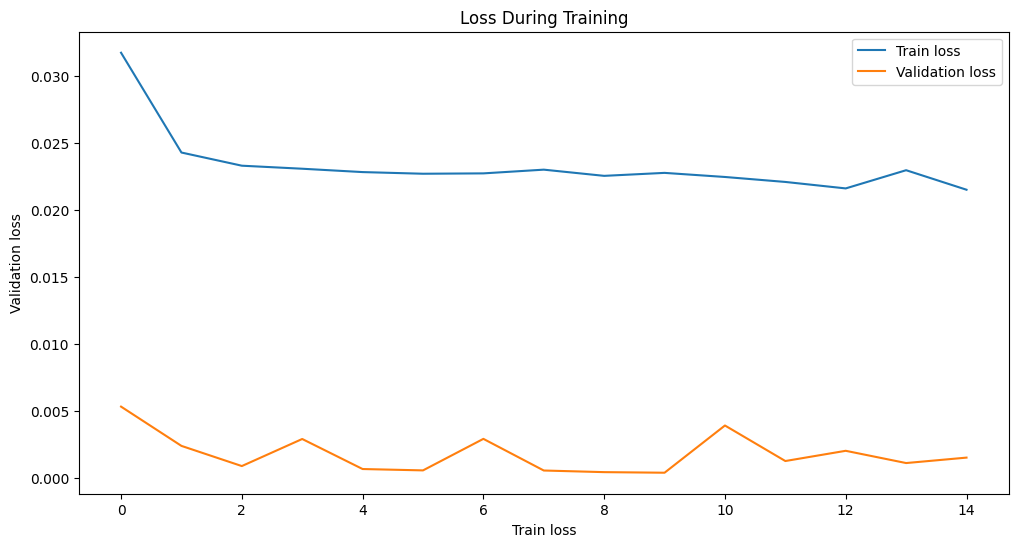

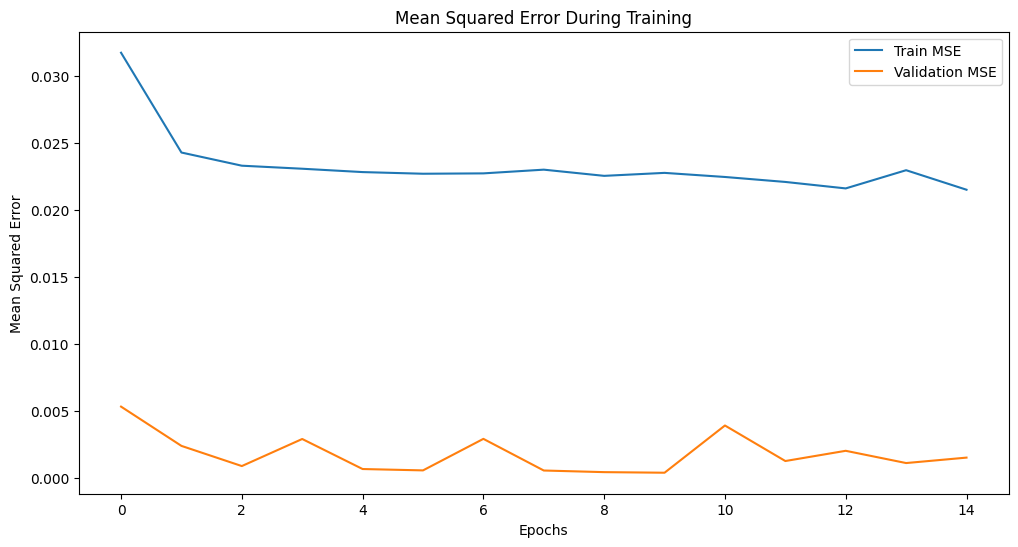

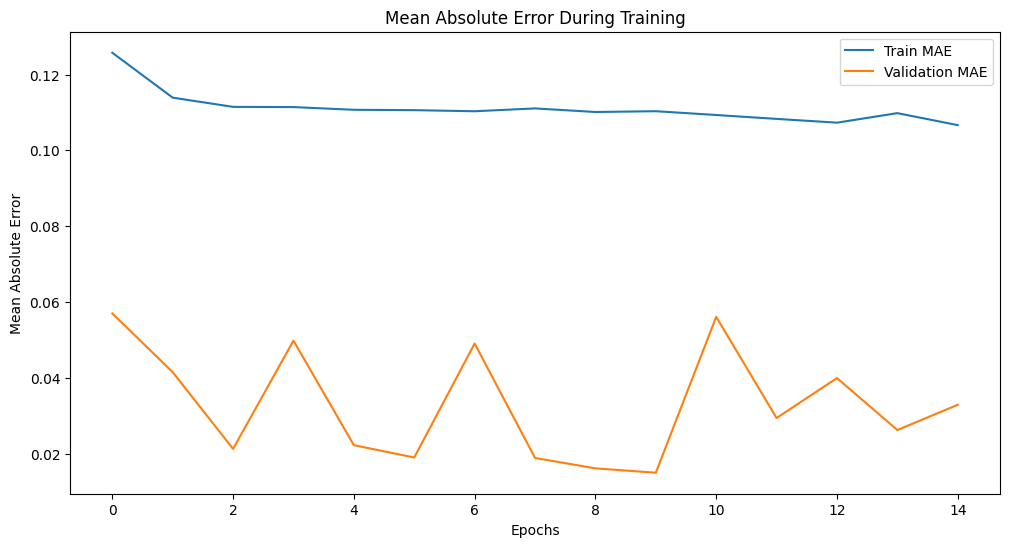

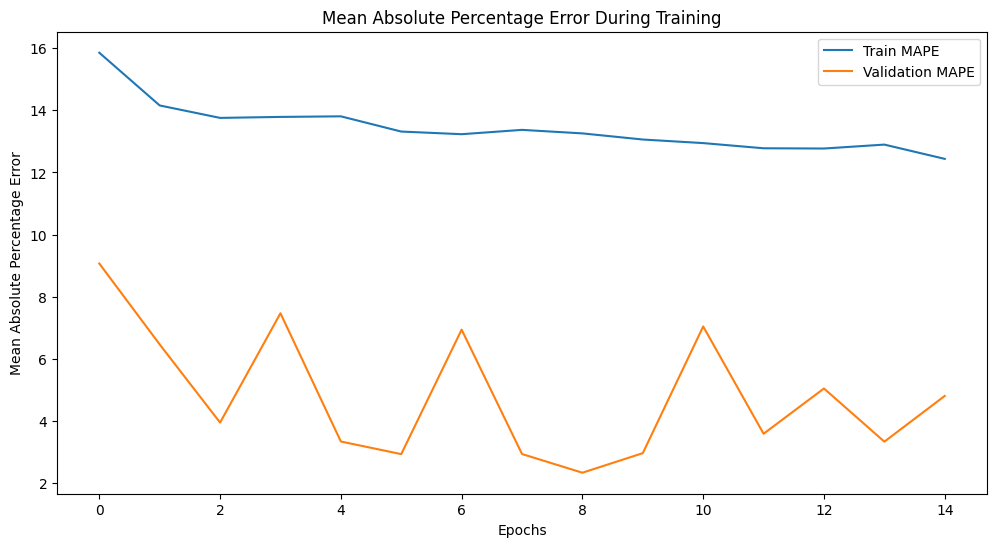

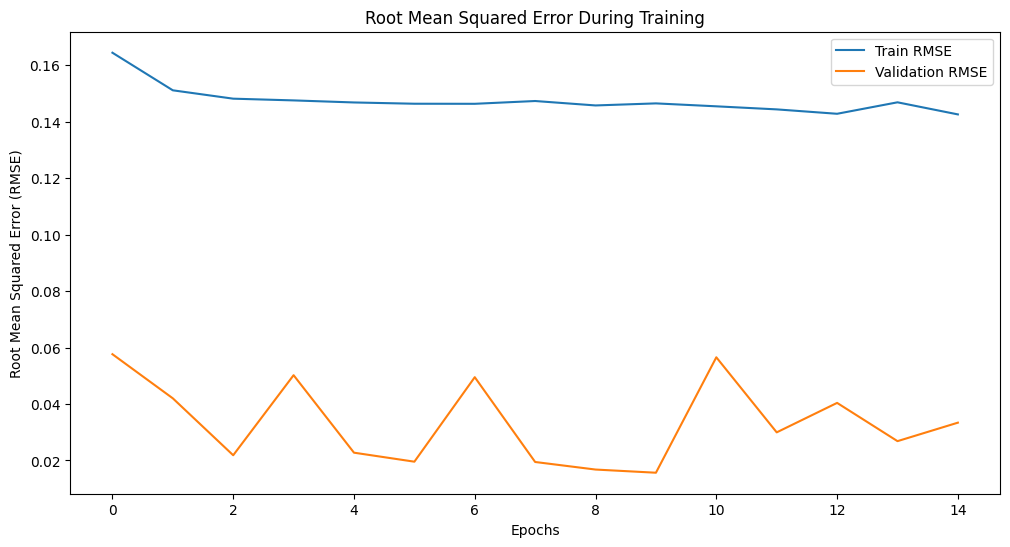

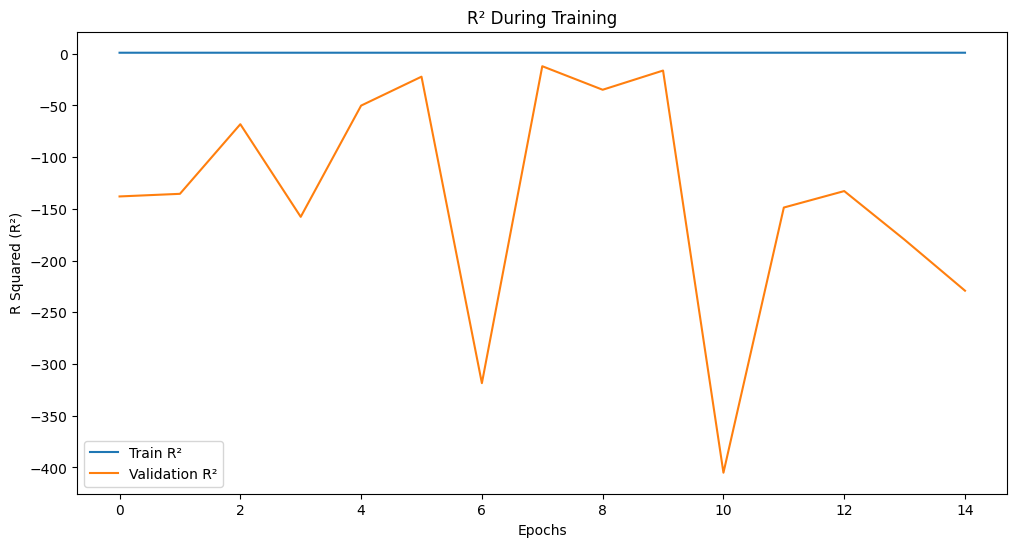

In [ ]:

# Plot Train and Validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Train loss')
plt.ylabel('Validation loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

# Plot Train and Validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_squared_error'], label='Train MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Mean Squared Error During Training')
plt.show()

# Plot Train and Validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Mean Absolute Error During Training')
plt.show()

# Plot Train and Validation MAPE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()
plt.title('Mean Absolute Percentage Error During Training')
plt.show()

# Plot Train and Validation RMSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['rmse_metric'], label='Train RMSE')
plt.plot(history.history['val_rmse_metric'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.title('Root Mean Squared Error During Training')
plt.show()

# Plot Train and Validation R²
plt.figure(figsize=(12, 6))
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R Squared (R²)')
plt.legend()
plt.title('R² During Training')
plt.show()

# Program Buat Upload dan Tambah dataset baru

In [ ]:
# 7
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the model and scaler
model = load_model('best_model_final_lstm_final.keras')  # Ganti dengan file model yang baru
scaler = joblib.load('scaler.pkl')  # Memuat scaler.pkl yang berisi StandardScaler

# Load historical data from a new CSV file
historical_file_path = 'New_Historical_Data.csv'  # Ganti dengan path file Anda
new_data = pd.read_csv(historical_file_path, delimiter=';')

# Preprocess the new data
# Data preprocessing
new_data['Time'] = pd.to_datetime(new_data['Time'], format='%d-%b-%y %H.%M.%S')
new_data['Temp Winding'] = new_data['Temp Winding'].str.replace(',', '.').astype(float)
new_data['MW'] = new_data['MW'].str.replace(',', '.').astype(float)
new_data['Mvar'] = new_data['Mvar'].str.replace(',', '.').astype(float)

# Calculate duration in seconds from the start time
new_data['Duration'] = (new_data['Time'] - new_data['Time'].min()).dt.total_seconds()

# Tambahkan kolom Previous Temperature (Suhu Sebelumnya) pada new_data
new_data.fillna(method='bfill', inplace=True)  # Isi NaN pada row pertama dengan nilai baris berikutnya

# Normalize the new data using the StandardScaler
new_data[['Temp Winding', 'Mvar', 'MW', 'Duration']] = scaler.transform(new_data[['Temp Winding', 'Mvar', 'MW', 'Duration']])

# Combine the new historical data with the existing data
data = pd.concat([data, new_data], ignore_index=True)

# Print a confirmation message
print("Historical data has been successfully added!")

# You can check the top rows of the data to confirm the changes
print(data.head())


# Bagian Prediksi

In [ ]:
# 8
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Define custom RMSE metric function
def rmse_metric(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Define custom R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Sum of squared residuals
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return (1 - ss_res / (ss_tot + K.epsilon()))  # Return R²

# Load the model and scaler
model = load_model('LSTM_Best_Model.keras', custom_objects={"rmse_metric": rmse_metric, "r2_metric": r2_metric})
scaler = joblib.load('LSTM_Scaler.pkl')  # Load scaler.pkl

# Input data from user
start_time = input("Enter start time (format: DD-MMM-YY HH.MM.SS): ")
current_time = input("Enter current time (format: DD-MMM-YY HH.MM.SS): ")
input_MW = float(input("Enter Active Power: "))
input_Mvar = float(input("Enter Reactive Power: "))

# Convert input times to datetime
start_time_dt = pd.to_datetime(start_time, format='%d-%b-%y %H.%M.%S')
current_time_dt = pd.to_datetime(current_time, format='%d-%b-%y %H.%M.%S')

# Calculate operation duration in seconds
durasi_operasi = (current_time_dt - start_time_dt).total_seconds()

# Normalize the input (including Temp Winding placeholder)
input_normalized = scaler.transform([[0, input_Mvar, input_MW, durasi_operasi]])

# Prepare the sequence for prediction
sequence_length = 20  # Adjust this based on your model's input sequence length

# # Get recent sequence (including placeholder for Temp Winding)
# recent_sequence = data[['Temp Winding', 'Mvar', 'MW', 'Duration']].values[-sequence_length:]
# # recent_sequence[:, 0] = 0  # Replace Temp Winding values with 0 (or use another placeholder if needed)

# # Append normalized input to the sequence
# input_sequence = np.vstack([recent_sequence[1:], input_normalized])  # Replace the oldest entry with input
# input_sequence = np.expand_dims(input_sequence, axis=0)  # Reshape for LSTM input

# Get recent sequence
recent_sequence = data[['Temp Winding', 'Mvar', 'MW', 'Duration']].values[-sequence_length:]
recent_sequence = scaler.transform(recent_sequence)  # Normalize

# Normalize input
input_normalized = scaler.transform([[0, input_Mvar, input_MW, durasi_operasi]])

# Append input to recent sequence
input_sequence = np.vstack([recent_sequence[1:], input_normalized])  # Replace the oldest entry with input
input_sequence = np.expand_dims(input_sequence, axis=0)  # Reshape for LSTM input


# Perform the prediction
predicted_temp_normalized = model.predict(input_sequence)[0][0]

# Inverse scale the prediction
placeholder = np.zeros((1, 4))  # Placeholder array with same shape as original data
placeholder[0, 0] = predicted_temp_normalized  # Set Temp Winding prediction
predicted_temp_original = scaler.inverse_transform(placeholder)[0][0]

# Print the prediction result
print(f"\nPredicted Temperature Winding:")
print(f"- Start Time: {start_time}")
print(f"- Current Time: {current_time}")
print(f"- Active Power: {input_MW} MW")
print(f"- Reactive Power: {input_Mvar} Mvar")
print(f"- Predicted Temperature: {predicted_temp_original:.2f}°C")


Enter start time (format: DD-MMM-YY HH.MM.SS): 27-jan-25 15.00.00
Enter current time (format: DD-MMM-YY HH.MM.SS): 27-jan-25 18.00.00
Enter Active Power: 145
Enter Reactive Power: 30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

Predicted Temperature Winding:
- Start Time: 27-jan-25 15.00.00
- Current Time: 27-jan-25 18.00.00
- Active Power: 145.0 MW
- Reactive Power: 30.0 Mvar
- Predicted Temperature: 57.68°C


In [ ]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Define custom RMSE metric function
def rmse_metric(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Define custom R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Sum of squared residuals
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return (1 - ss_res / (ss_tot + K.epsilon()))  # Return R²


# Load the model and scaler
model = load_model('LSTM_Best_Model.keras', custom_objects={"rmse_metric": rmse_metric, "r2_metric": r2_metric})
scaler = joblib.load('LSTM_Scaler.pkl')  # Load scaler.pkl


# User input
start_time = input("Enter start time (format: DD-MMM-YY HH.MM.SS): ")
current_time = input("Enter current time (format: DD-MMM-YY HH.MM.SS): ")
input_MW = float(input("Enter Active Power: "))
input_Mvar = float(input("Enter Reactive Power: "))

# Convert input times to datetime
start_time_dt = pd.to_datetime(start_time, format='%d-%b-%y %H.%M.%S')
current_time_dt = pd.to_datetime(current_time, format='%d-%b-%y %H.%M.%S')

# Calculate operation duration in seconds
duration = (current_time_dt - start_time_dt).total_seconds()

# Construct input data
data_input = np.array([[0,input_Mvar, input_MW, duration]])  # No placeholder for Temp Winding

# Normalize input
data_input_scaled = scaler.transform(data_input)

# Reshape input for LSTM
input_sequence = np.expand_dims(data_input_scaled, axis=0)  # LSTM expects 3D input

# Predict temperature
predicted_temp_scaled = model.predict(input_sequence)[0][0]

# Inverse transform prediction to original scale
predicted_temp_original = scaler.inverse_transform(
    np.array([[predicted_temp_scaled, 0, 0, 0]])
)[0][0]  # Only take Temp Winding inverse-transformed value

# Print prediction result
print(f"\nPredicted Temperature Winding:")
print(f"- Start Time: {start_time}")
print(f"- Current Time: {current_time}")
print(f"- Active Power: {input_MW} MW")
print(f"- Reactive Power: {input_Mvar} Mvar")
print(f"- Predicted Temperature: {predicted_temp_original:.2f}°C")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Enter start time (format: DD-MMM-YY HH.MM.SS): 30-jan-25 08.00.00
Enter current time (format: DD-MMM-YY HH.MM.SS): 30-jan-25 12.00.00
Enter Active Power: 125
Enter Reactive Power: -15


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step

Predicted Temperature Winding:
- Start Time: 30-jan-25 08.00.00
- Current Time: 30-jan-25 12.00.00
- Active Power: 125.0 MW
- Reactive Power: -15.0 Mvar
- Predicted Temperature: 50.97°C


# LSTM Predict data 3 hari

In [ ]:
# Re-load necessary libraries since execution state was reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler

# Define custom RMSE metric function
def rmse_metric(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Define custom R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Sum of squared residuals
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return (1 - ss_res / (ss_tot + K.epsilon()))  # Return R²

# Reload the trained model and scaler
model_path = "LSTM_Best_Model.keras"  # Update with correct path if needed
scaler_path = "LSTM_Scaler.pkl"  # Update with correct path if needed

model = load_model(model_path, custom_objects={"rmse_metric": rmse_metric, "r2_metric": r2_metric})
scaler = joblib.load(scaler_path)

# Load the new dataset for prediction
file_path = "Data 3 hari terakhir.csv"
new_data = pd.read_csv(file_path, delimiter=';')

# Convert 'Time' column to datetime
new_data['Time'] = pd.to_datetime(new_data['Time'], format='%d/%m/%Y %H.%M')

# Convert numeric columns replacing ',' with '.' for proper parsing
new_data['Temp Winding'] = pd.to_numeric(new_data['Temp Winding'].str.replace(',', '.'), errors='coerce')
new_data['MW'] = pd.to_numeric(new_data['MW'].str.replace(',', '.'), errors='coerce')
new_data['Mvar'] = pd.to_numeric(new_data['Mvar'].str.replace(',', '.'), errors='coerce')

# Drop rows with NaN values
new_data.dropna(inplace=True)

# Calculate operation duration in seconds
new_data['Duration'] = (new_data['Time'] - new_data['Time'].iloc[0]).dt.total_seconds()

# Normalize the data using the same scaler
new_data_scaled = scaler.transform(new_data[['Temp Winding', 'Mvar', 'MW', 'Duration']])

# Prepare the test sequences for LSTM
sequence_length = 20  # Must match training sequence length

X_test = []
y_test = []

for i in range(sequence_length, len(new_data_scaled)):
    X_test.append(new_data_scaled[i-sequence_length:i, :])
    y_test.append(new_data_scaled[i, 0])  # Target is Temp Winding

X_test, y_test = np.array(X_test), np.array(y_test)

# Predict using the trained LSTM model
y_pred_scaled = model.predict(X_test).flatten()

# Inverse transform predictions
y_pred = scaler.inverse_transform(np.column_stack([y_pred_scaled, np.zeros((len(y_pred_scaled), 3))]))[:, 0]
y_actual = new_data['Temp Winding'].values[sequence_length:]

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)
rmse_value = rmse(y_actual, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse_value:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MAE: 2.0295
MSE: 11.3616
MAPE: 0.0375
R2 Score: 0.8830
RMSE: 3.3707


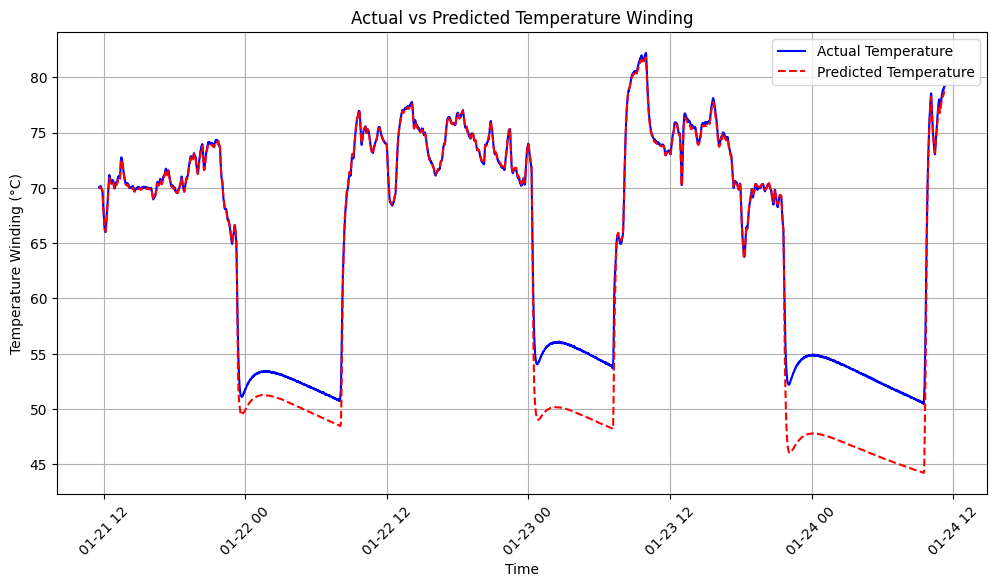

In [ ]:

# Plot Actual vs Prediction
plt.figure(figsize=(12, 6))
plt.plot(new_data['Time'].values[sequence_length:], y_actual, label='Actual Temperature', color='blue')
plt.plot(new_data['Time'].values[sequence_length:], y_pred, label='Predicted Temperature', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Temperature Winding (°C)')
plt.title('Actual vs Predicted Temperature Winding')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# RANDOM FOREST REGRESSOR

In [ ]:
# 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, send_file

# Load data
file_path = 'Data 3 hari terakhir.csv'
data = pd.read_csv(file_path, delimiter=';')

# Data preprocessing
data['Time'] = pd.to_datetime(data['Time'], format='%d/%m/%Y %H.%M')

# Replace non-numeric values with NaN in the relevant columns and convert to numeric
data['Temp Winding'] = pd.to_numeric(data['Temp Winding'].str.replace(',', '.'), errors='coerce')
data['MW'] = pd.to_numeric(data['MW'].str.replace(',', '.'), errors='coerce')
data['Mvar'] = pd.to_numeric(data['Mvar'].str.replace(',', '.'), errors='coerce')

# Drop rows with NaN values after the conversion
data.dropna(inplace=True)

# Initialize starttime variable with the time of the first data point
starttime = data['Time'].iloc[0]

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

# Apply the function to calculate Duration
data['Duration'] = data.apply(calculate_duration, axis=1)

# Save the cleaned and updated data
data.head()


,Time,Temp Winding,Mvar,MW,Duration
0,2025-01-21 11:17:00,70.183151,36.475464,127.539749,0.0
1,2025-01-21 11:18:00,70.226288,36.832169,127.565331,60.0
2,2025-01-21 11:19:00,70.183151,34.141895,125.256081,120.0
3,2025-01-21 11:20:00,70.231995,34.061012,126.387161,180.0
4,2025-01-21 11:21:00,70.162369,34.842468,125.239883,240.0


In [ ]:
from google.colab import files
# Simpan data ke file CSV
output_file = 'Data 3 hari terakhir rapih.csv'
data.to_csv(output_file, index=False)

# Unduh file CSV
print(f"File '{output_file}' telah dibuat. Anda dapat mengunduhnya di bawah ini:")
files.download(output_file)

File 'Data 3 hari terakhir rapih.csv' telah dibuat. Anda dapat mengunduhnya di bawah ini:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2.5
# # Drop baris dengan Duration = 0
# data = data[data['Duration'] > 0]
# data.head()

In [ ]:
# 3
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler

# Define features and target
X = data[['Mvar', 'MW', 'Duration']]
y = data['Temp Winding']

# Apply Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X = pd.DataFrame(X_scaled, columns=X.columns)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Save the model and scaler
with open('RFR_Model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
with open('RFR_Scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 2.46
Mean Squared Error (MSE): 13.05
Root Mean Squared Error (RMSE): 3.61
R-squared (R²): 0.92
Mean Absolute Percentage Error (MAPE): 5.02%


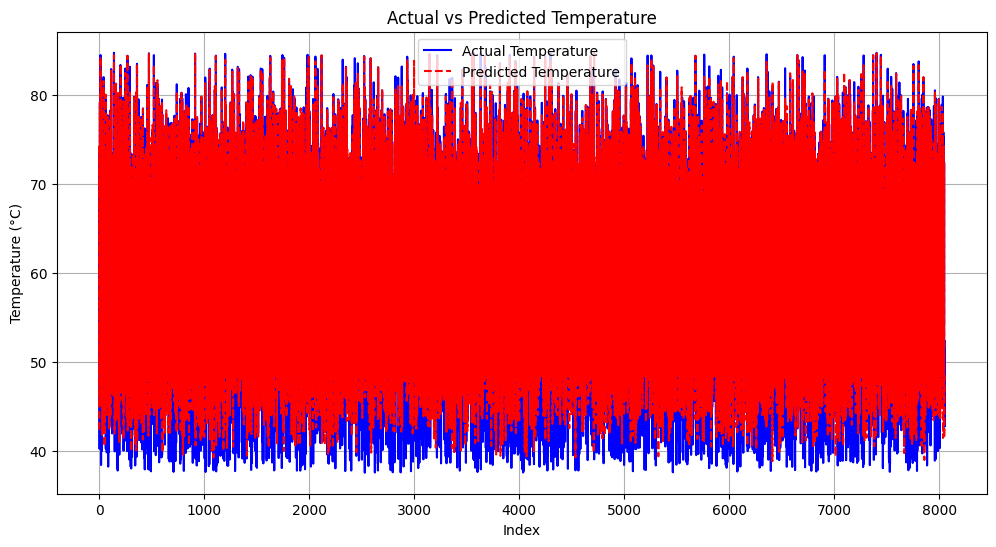

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Temperature', color='blue')
plt.plot(y_pred, label='Predicted Temperature', color='red', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.grid()
plt.show()


# Program Prediksi RandomForestRegressor

In [ ]:

# Function for user input prediction
def user_input_prediction():
    # Load model and scaler
    with open('RFR_Model.pkl', 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    with open('RFR_Scaler.pkl', 'rb') as scaler_file:
        loaded_scaler = pickle.load(scaler_file)

    start_time_str = input("Masukkan Start Time (DD-MMM-YY HH.MM.SS): ")
    current_time_str = input("Masukkan Current Time (DD-MMM-YY HH.MM.SS): ")
    mvar = float(input("Masukkan nilai Mvar: "))
    mw = float(input("Masukkan nilai MW: "))

    start_time = datetime.strptime(start_time_str, "%d-%b-%y %H.%M.%S")
    current_time = datetime.strptime(current_time_str, "%d-%b-%y %H.%M.%S")

    duration = (current_time - start_time).total_seconds()
    input_data = np.array([[mvar, mw, duration]])
    input_data_scaled = loaded_scaler.transform(input_data)

    predicted_temp = loaded_model.predict(input_data_scaled)[0]

    print("\n--- Informasi Input dan Prediksi ---")
    print(f"Start Time: {start_time_str}")
    print(f"Current Time: {current_time_str}")
    print(f"Durasi (detik): {duration}")
    print(f"Mvar: {mvar}")
    print(f"MW: {mw}")
    print(f"Prediksi Suhu Winding: {predicted_temp:.2f}°C")

if __name__ == "__main__":
    user_input_prediction()

# Program Tambah data


In [ ]:
# 7
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Load new historical data
historical_file_path = 'New_Historical_Data.csv'
new_data = pd.read_csv(historical_file_path, delimiter=';')

# Preprocess new data
new_data['Time'] = pd.to_datetime(new_data['Time'], format='%d-%b-%y %H.%M.%S')
new_data['Temp Winding'] = pd.to_numeric(new_data['Temp Winding'].str.replace(',', '.'), errors='coerce')
new_data['MW'] = pd.to_numeric(new_data['MW'].str.replace(',', '.'), errors='coerce')
new_data['Mvar'] = pd.to_numeric(new_data['Mvar'].str.replace(',', '.'), errors='coerce')

new_data.dropna(inplace=True)
new_data['Duration'] = (new_data['Time'] - new_data['Time'].min()).dt.total_seconds()


# Initialize starttime variable with the time of the first data point
starttime = new_data['Time'].iloc[0]

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

# Apply the function to calculate Duration
new_data['Duration'] = new_data.apply(calculate_duration, axis=1)

# # Drop baris dengan Duration = 0
# data = data[data['Duration'] > 0]

# Normalize new data using the StandardScaler
new_data[['Mvar', 'MW', 'Duration']] = scaler.transform(new_data[['Mvar', 'MW', 'Duration']])

# Append new historical data to existing dataset
data = pd.concat([data, new_data], ignore_index=True)

print("Historical data has been successfully added!")
print(data.head())


# Coba Prediksi pake data 3 hari

In [ ]:
# 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, send_file

# Load data
file_path = 'Data 3 hari terakhir.csv'
data2 = pd.read_csv(file_path, delimiter=';')

# Data preprocessing
data2['Time'] = pd.to_datetime(data2['Time'], format='%d/%m/%Y %H.%M')

# Replace non-numeric values with NaN in the relevant columns and convert to numeric
data2['Temp Winding'] = pd.to_numeric(data2['Temp Winding'].str.replace(',', '.'), errors='coerce')
data2['MW'] = pd.to_numeric(data2['MW'].str.replace(',', '.'), errors='coerce')
data2['Mvar'] = pd.to_numeric(data2['Mvar'].str.replace(',', '.'), errors='coerce')

# Drop rows with NaN values after the conversion
data2.dropna(inplace=True)

# Initialize starttime variable with the time of the first data point
starttime = pd.to_datetime("21/01/2025 08.13", format="%d/%m/%Y %H.%M")

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

# Apply the function to calculate Duration
data2['Duration'] = data2.apply(calculate_duration, axis=1)

# # Save the cleaned and updated data
# data2.head()

# 2.5
# # Drop baris dengan Duration = 0
# data2 = data2[data2['Duration'] > 0]
# data2.head()

# Load model and scaler
with open('RFR_Model.pkl', 'rb') as model_file:
  loaded_model = pickle.load(model_file)
with open('RFR_Scaler.pkl', 'rb') as scaler_file:
  loaded_scaler = pickle.load(scaler_file)

X2 = data2[['Mvar', 'MW', 'Duration']]
y2 = data2['Temp Winding']

X_scaled2 = loaded_scaler.fit_transform(X2)
# Make predictions
y_pred2 = loaded_model.predict(X_scaled2)


# Evaluate the model
mae2 = mean_absolute_error(y2, y_pred2)
mse2 = mean_squared_error(y2, y_pred2)
rmse2 = np.sqrt(mse2)
r22 = r2_score(y2, y_pred2)
mape2 = np.mean(np.abs((y2 - y_pred2) / y2)) * 100

print(f"Mean Absolute Error (MAE): {mae2:.2f}")
print(f"Mean Squared Error (MSE): {mse2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse2:.2f}")
print(f"R-squared (R²): {r22:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape2:.2f}%")


Mean Absolute Error (MAE): 4.23
Mean Squared Error (MSE): 30.45
Root Mean Squared Error (RMSE): 3.61
R-squared (R²): 0.69
Mean Absolute Percentage Error (MAPE): 6.40%


In [ ]:

# Save the cleaned and updated data
data2.head()

,Time,Temp Winding,Mvar,MW,Duration
0,2025-01-21 11:17:00,70.183151,36.475464,127.539749,11040.0
1,2025-01-21 11:18:00,70.226288,36.832169,127.565331,11100.0
2,2025-01-21 11:19:00,70.183151,34.141895,125.256081,11160.0
3,2025-01-21 11:20:00,70.231995,34.061012,126.387161,11220.0
4,2025-01-21 11:21:00,70.162369,34.842468,125.239883,11280.0


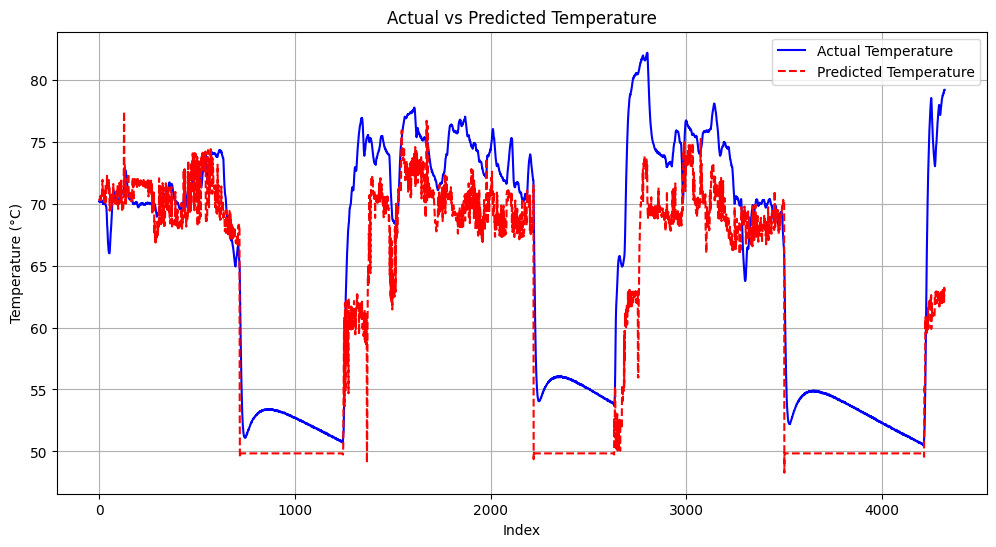

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y2.values, label='Actual Temperature', color='blue')
plt.plot(y_pred2, label='Predicted Temperature', color='red', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.grid()
plt.show()


# XGBOOST Model

In [ ]:
!pip uninstall -y scikit-learn xgboost
!pip install scikit-learn==1.2.2 xgboost==1.7.6

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from flask import Flask, request, jsonify, send_file
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# XGBoost
from xgboost import XGBRegressor

# 1) Load data
file_path = 'Data 27 hari.csv'
data2 = pd.read_csv(file_path, delimiter=';')

# 2) Data preprocessing
data2['Time'] = pd.to_datetime(data2['Time'], format='%d/%m/%Y %H.%M')

# Replace non-numeric values with NaN in the relevant columns and convert to numeric
data2['Temp Winding'] = pd.to_numeric(data2['Temp Winding'].str.replace(',', '.'), errors='coerce')
data2['MW'] = pd.to_numeric(data2['MW'].str.replace(',', '.'), errors='coerce')
data2['Mvar'] = pd.to_numeric(data2['Mvar'].str.replace(',', '.'), errors='coerce')

# Drop rows with NaN values after the conversion
data2.dropna(inplace=True)

# 3) Mengatur starttime manual seperti permintaan
starttime = pd.to_datetime("21/01/2025 08.13", format="%d/%m/%Y %H.%M")

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

data2['Duration'] = data2.apply(calculate_duration, axis=1)

data2.head()



,Time,Temp Winding,Mvar,MW,Duration
0,2024-12-24 12:21:00,75.115997,8.858432,0.155644,0.0
1,2024-12-24 12:22:00,73.420670,1.512335,0.155644,0.0
2,2024-12-24 12:23:00,71.759880,0.704978,0.155644,0.0
3,2024-12-24 12:24:00,70.147820,0.388237,0.155644,0.0
4,2024-12-24 12:25:00,68.571434,0.228889,0.153084,0.0


In [ ]:
data2.sample(20)

,Time,Temp Winding,Mvar,MW,Duration
12166,2025-01-01 23:07:00,48.156288,-0.113225,0.155644,0.0
35759,2025-01-18 08:20:00,51.379734,-0.109867,0.146489,0.0
5542,2024-12-28 08:43:00,49.265854,-0.119022,0.149005,0.0
35120,2025-01-17 21:41:00,66.192406,1.353607,111.936958,32040.0
15708,2025-01-04 10:09:00,41.709404,-0.113528,0.146489,0.0
9592,2024-12-31 04:13:00,43.956043,-0.119022,0.155644,0.0
31658,2025-01-15 11:59:00,79.560440,23.157953,154.716919,16440.0
16928,2025-01-05 06:29:00,38.716621,-0.115800,0.155644,0.0
30032,2025-01-14 08:53:00,68.962151,19.658581,131.580948,14640.0
917,2024-12-25 03:38:00,53.012577,-0.109867,0.155644,0.0


In [ ]:
# (Opsional) Hapus baris Durasi=0 jika tidak ingin menyertakan data generator off
data2 = data2[data2['Duration'] > 0]

In [ ]:
data2.head()

,Time,Temp Winding,Mvar,MW,Duration
50,2024-12-24 13:11:00,55.607529,2.524554,16.576149,60.0
51,2024-12-24 13:12:00,55.544914,4.380395,82.962982,120.0
52,2024-12-24 13:13:00,55.593781,7.582377,115.741806,180.0
53,2024-12-24 13:14:00,56.019539,12.307958,159.216263,240.0
54,2024-12-24 13:15:00,56.982655,14.658194,169.155029,300.0


In [ ]:
data2.sample(20)

,Time,Temp Winding,Mvar,MW,Duration
34811,2025-01-17 16:32:00,75.932396,28.022221,143.196304,13500.0
23338,2025-01-09 17:19:00,69.597069,18.548283,131.376373,42060.0
22278,2025-01-08 23:39:00,77.432953,15.514650,146.429550,60420.0
33756,2025-01-16 22:57:00,72.144829,16.664139,130.922638,122280.0
31513,2025-01-15 09:34:00,72.108894,32.179516,129.627930,7740.0
36508,2025-01-18 20:49:00,65.431984,-2.537650,116.543457,9660.0
18292,2025-01-06 05:13:00,70.616310,8.662304,158.316742,39840.0
37061,2025-01-19 06:02:00,61.245422,-15.881759,102.585648,42840.0
13183,2025-01-02 16:04:00,67.594627,-3.640691,109.943474,25320.0
3095,2024-12-26 15:56:00,69.010994,9.726655,84.179741,25320.0


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Mean Absolute Error (MAE): 0.97
Mean Squared Error (MSE): 2.24
Root Mean Squared Error (RMSE): 1.50
R-squared (R²): 0.91
Mean Absolute Percentage Error (MAPE): 1.37%


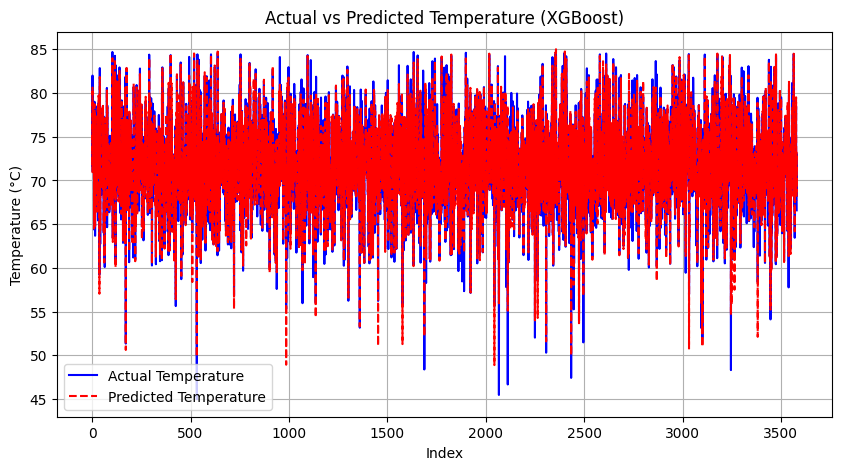

In [ ]:

# 4) Pisahkan fitur dan target
X2 = data2[['Mvar', 'MW', 'Duration']]
y2 = data2['Temp Winding']

# 5) Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# 6) Scaling data (MinMax atau Standard, sesuai kebutuhan)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7) Definisikan model XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# 8) Siapkan parameter untuk tuning
# Anda bisa menyesuaikan parameter-grid ini sesuai kebutuhan
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 9) Lakukan Hyperparameter Tuning dengan RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,                # jumlah iterasi random sampling
    scoring='neg_mean_squared_error',
    cv=3,                     # k-fold CV
    verbose=1,
    random_state=42,
    n_jobs=-1                # gunakan semua core CPU
)

random_search.fit(X_train_scaled, y_train)

# Dapatkan model terbaik
best_xgb_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# 10) Lakukan prediksi dengan model terbaik
y_pred_test = best_xgb_model.predict(X_test_scaled)

# 11) Evaluasi model
mae2 = mean_absolute_error(y_test, y_pred_test)
mse2 = mean_squared_error(y_test, y_pred_test)
rmse2 = np.sqrt(mse2)
r22 = r2_score(y_test, y_pred_test)
mape2 = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae2:.2f}")
print(f"Mean Squared Error (MSE): {mse2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse2:.2f}")
print(f"R-squared (R²): {r22:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape2:.2f}%")

# 12) (Opsional) Visualisasi Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test.values, label='Actual Temperature', color='blue')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Temperature', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (XGBoost)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 13) Simpan model terbaik dan scaler
with open('best_xgb_model2.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

with open('xgb_scaler2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler have been saved successfully!")

Model and scaler have been saved successfully!


In [ ]:
# 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, send_file

# Load data
file_path = 'Data 3 hari terakhir.csv'
data2 = pd.read_csv(file_path, delimiter=';')

# Data preprocessing
data2['Time'] = pd.to_datetime(data2['Time'], format='%d/%m/%Y %H.%M')

# Replace non-numeric values with NaN in the relevant columns and convert to numeric
data2['Temp Winding'] = pd.to_numeric(data2['Temp Winding'].str.replace(',', '.'), errors='coerce')
data2['MW'] = pd.to_numeric(data2['MW'].str.replace(',', '.'), errors='coerce')
data2['Mvar'] = pd.to_numeric(data2['Mvar'].str.replace(',', '.'), errors='coerce')

# Drop rows with NaN values after the conversion
data2.dropna(inplace=True)

# Initialize starttime variable with the time of the first data point
starttime = pd.to_datetime("21/01/2025 08.13", format="%d/%m/%Y %H.%M")

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

# Apply the function to calculate Duration
data2['Duration'] = data2.apply(calculate_duration, axis=1)

# # Save the cleaned and updated data
# data2.head()

# 2.5
# # Drop baris dengan Duration = 0
# data2 = data2[data2['Duration'] > 0]
# data2.head()

# Load model and scaler
with open('best_xgb_model.pkl', 'rb') as model_file:
  loaded_model = pickle.load(model_file)
with open('xgb_scaler.pkl', 'rb') as scaler_file:
  loaded_scaler = pickle.load(scaler_file)

X2 = data2[['Mvar', 'MW', 'Duration']]
y2 = data2['Temp Winding']

X_scaled2 = loaded_scaler.fit_transform(X2)
# Make predictions
y_pred2 = loaded_model.predict(X_scaled2)


# Evaluate the model
mae2 = mean_absolute_error(y2, y_pred2)
mse2 = mean_squared_error(y2, y_pred2)
rmse2 = np.sqrt(mse2)
r22 = r2_score(y2, y_pred2)
mape2 = np.mean(np.abs((y2 - y_pred2) / y2)) * 100

print(f"Mean Absolute Error (MAE): {mae2:.2f}")
print(f"Mean Squared Error (MSE): {mse2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse2:.2f}")
print(f"R-squared (R²): {r22:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape2:.2f}%")


Mean Absolute Error (MAE): 3.52
Mean Squared Error (MSE): 17.81
Root Mean Squared Error (RMSE): 4.22
R-squared (R²): 0.82
Mean Absolute Percentage Error (MAPE): 5.80%


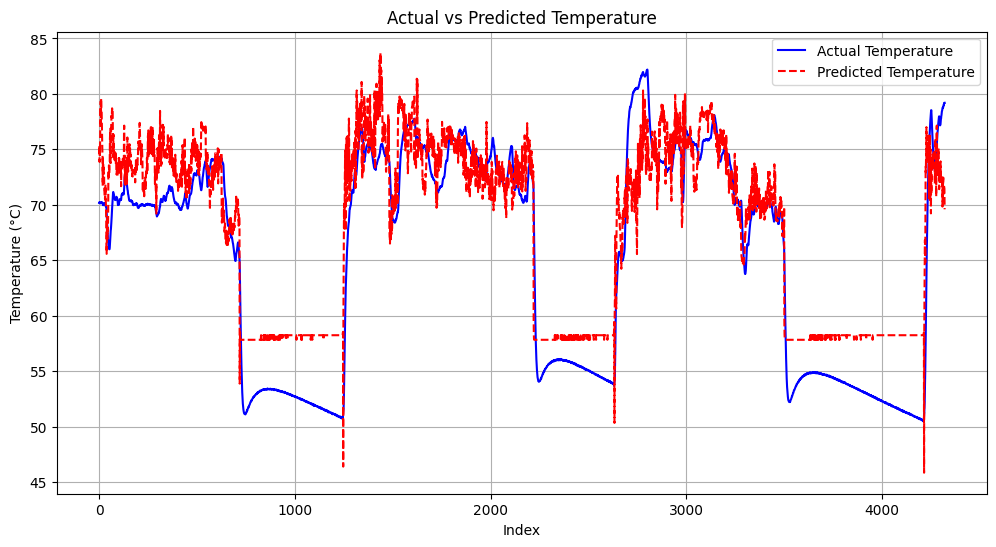

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y2.values, label='Actual Temperature', color='blue')
plt.plot(y_pred2, label='Predicted Temperature', color='red', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.grid()
plt.show()



In [ ]:

# Function for user input prediction
def user_input_prediction():
    # Load model and scaler
    with open('best_xgb_model.pkl', 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    with open('xgb_scaler.pkl', 'rb') as scaler_file:
        loaded_scaler = pickle.load(scaler_file)

    start_time_str = input("Masukkan Start Time (DD-MMM-YY HH.MM.SS): ")
    current_time_str = input("Masukkan Current Time (DD-MMM-YY HH.MM.SS): ")
    mvar = float(input("Masukkan nilai Mvar: "))
    mw = float(input("Masukkan nilai MW: "))

    start_time = datetime.strptime(start_time_str, "%d-%b-%y %H.%M.%S")
    current_time = datetime.strptime(current_time_str, "%d-%b-%y %H.%M.%S")

    duration = (current_time - start_time).total_seconds()
    input_data = np.array([[mvar, mw, duration]])
    input_data_scaled = loaded_scaler.transform(input_data)

    predicted_temp = loaded_model.predict(input_data_scaled)[0]

    print("\n--- Informasi Input dan Prediksi ---")
    print(f"Start Time: {start_time_str}")
    print(f"Current Time: {current_time_str}")
    print(f"Durasi (detik): {duration}")
    print(f"Mvar: {mvar}")
    print(f"MW: {mw}")
    print(f"Prediksi Suhu Winding: {predicted_temp:.2f}°C")

if __name__ == "__main__":
    user_input_prediction()

Masukkan Start Time (DD-MMM-YY HH.MM.SS): 30-jan-25 12.00.00
Masukkan Current Time (DD-MMM-YY HH.MM.SS): 30-jan-25 18.00.00
Masukkan nilai Mvar: 30
Masukkan nilai MW: 145

--- Informasi Input dan Prediksi ---
Start Time: 30-jan-25 12.00.00
Current Time: 30-jan-25 18.00.00
Durasi (detik): 21600.0
Mvar: 30.0
MW: 145.0
Prediksi Suhu Winding: 75.93°C


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 7
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Load new historical data
historical_file_path = 'New_Historical_Data.csv'
new_data = pd.read_csv(historical_file_path, delimiter=';')

# Preprocess new data
new_data['Time'] = pd.to_datetime(new_data['Time'], format='%d-%b-%y %H.%M.%S')
new_data['Temp Winding'] = pd.to_numeric(new_data['Temp Winding'].str.replace(',', '.'), errors='coerce')
new_data['MW'] = pd.to_numeric(new_data['MW'].str.replace(',', '.'), errors='coerce')
new_data['Mvar'] = pd.to_numeric(new_data['Mvar'].str.replace(',', '.'), errors='coerce')

new_data.dropna(inplace=True)
new_data['Duration'] = (new_data['Time'] - new_data['Time'].min()).dt.total_seconds()


# Initialize starttime variable with the time of the first data point
starttime = new_data['Time'].iloc[0]

def calculate_duration(row):
    global starttime
    if row['MW'] < 1:
        # Generator is off, reset Duration and update starttime
        starttime = row['Time']
        return 0
    else:
        # Generator is on, calculate duration from the last starttime
        return (row['Time'] - starttime).total_seconds()

# Apply the function to calculate Duration
new_data['Duration'] = new_data.apply(calculate_duration, axis=1)

# # Drop baris dengan Duration = 0
# data = data[data['Duration'] > 0]

# Normalize new data using the StandardScaler
new_data[['Mvar', 'MW', 'Duration']] = scaler.transform(new_data[['Mvar', 'MW', 'Duration']])

# Append new historical data to existing dataset
data = pd.concat([data, new_data], ignore_index=True)

print("Historical data has been successfully added!")
print(data.head())


# DBF to CSV


In [ ]:
!python --version
!pip install dbfread

Python 3.11.11
  Using cached dbfread-2.0.7-py2.py3-none-any.whl.metadata (3.3 kB)


In [ ]:
import csv
from dbfread import DBF

def dbf_to_csv(dbf_table_pth):
    csv_fn = dbf_table_pth[:-4]+ ".csv"
    table = DBF(dbf_table_pth)
    with open(csv_fn, 'w', newline = '') as f:
        writer = csv.writer(f)
        writer.writerow(table.field_names)
        for record in table:
            writer.writerow([str(value) for value in record.values()]) # Konversi ke string
    return csv_fn

file_path = 'beban_10.dbf'
dbf_to_csv(file_path)

'beban_10.csv'

In [ ]:
# import csv
# from dbfread import DBF

# def dbf_to_csv(dbf_table_pth):
#     csv_fn = dbf_table_pth[:-4] + ".csv"
#     table = DBF(dbf_table_pth, encoding='latin1')  # atau 'utf-8' atau encoding lainnya
#     with open(csv_fn, 'w', newline='', encoding='utf-8') as f: # Sesuaikan encoding file output
#         writer = csv.writer(f)
#         writer.writerow(table.field_names)
#         for record in table:
#             writer.writerow([str(value) for value in record.values()])
#     return csv_fn

# file_path = 'beban_10.dbf'
# dbf_to_csv(file_path)

In [ ]:
# from dbfread import DBF
# import pandas as pd

# dbf_file_path = "beban_10.dbf"  # Sesuaikan path file
# table = DBF(dbf_file_path, encoding='latin1')
# df = pd.DataFrame(iter(table))

# csv_file_path = "beban_10.csv"
# df.to_csv(csv_file_path, index=False, encoding='utf-8')

# print(f"File CSV telah disimpan di: {csv_file_path}")

In [ ]:
# import pandas as pd
# import dbf

# # Path file DBF yang diunggah
# dbf_file_path = "beban_10.dbf"

# # Membaca file DBF
# table = dbf.Table(dbf_file_path)
# table.open()

# # Konversi ke DataFrame
# df = pd.DataFrame([record for record in table])

# # Menyimpan sebagai CSV
# csv_file_path = "beban_10.csv"
# df.to_csv(csv_file_path, index=False, encoding='utf-8')

# # Menampilkan dataframe ke pengguna
# import ace_tools as tools
# tools.display_dataframe_to_user(name="DBF to CSV", dataframe=df)

# # Menutup tabel
# table.close()

# # Memberikan tautan unduhan ke pengguna
# csv_file_path
